# Flow predictor

Data processing, model training and analysis

In [49]:
%matplotlib widget
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, RadioButtons, CheckButtons
from IPython.display import display, Markdown
plt.close("all")

## Data pre-processing

In [130]:
# Helper function to lag a column by x days
def lag_column(frame, col, days, change_name):
    frame[col] = frame[col].shift(days)
    if change_name:
        sign = "-" if days >= 0 else "+"
        frame = frame.rename(columns={col: col + f" (t{sign}{abs(days)})"})
    return frame

# Read Excel data into DataFrame
initial_df = pd.read_excel("data.xlsx", header=[0, 1], index_col=0)
initial_df.columns = initial_df.columns.set_levels(["r", "f"], level=0)
initial_df.index = initial_df.index.to_series().dt.date
initial_df = initial_df.rename_axis(index="date")

# Anonymise data, the rightmost flow column is chosen as predictand "p"
DF_F_COLS = [f"f{i}" for i in range(1, len(initial_df["f"].columns))]
DF_R_COLS = [f"r{i}" for i in range(1, len(initial_df["r"].columns)+1)]
initial_df.columns = DF_F_COLS + ["p"] + DF_R_COLS
initial_df = initial_df.reindex(columns = DF_F_COLS + DF_R_COLS + ["p"])

# Discard spurious data
initial_df = initial_df.apply(pd.to_numeric, errors="coerce")
initial_df = initial_df[initial_df >= 0]
initial_df.loc[:, DF_R_COLS] = initial_df.loc[:, DF_R_COLS][initial_df.loc[:, DF_R_COLS]<=279]

# Copy the DataFrame before discarding values
# as we will use the initial frame for visualization
df = initial_df.copy()
initial_df.dropna(inplace=True)

# UNCOMMENT THIS FOR STD DEV CULLING
# df = df[np.abs(df - df.std()) <= df.mean() + 3 * df.std()]
for col in df.columns.values:
    if col != "p":
        df = lag_column(df, col, 1, False)

df.dropna(inplace=True)

display(Markdown(f"#### Initial Data - 5 rows ({initial_df.shape[0]} total)\n---"))
display(Markdown(initial_df.head().to_markdown()))
display(Markdown(f"#### After Processing - 5 rows ({df.shape[0]} total)\n---"))
display(Markdown(df.head().to_markdown()))


#### Initial Data - 5 rows (1450 total)
---

| date       |    f1 |     f2 |     f3 |   r1 |   r2 |   r3 |    r4 |     p |
|:-----------|------:|-------:|-------:|-----:|-----:|-----:|------:|------:|
| 1993-01-01 | 10.4  |  4.393 |  9.291 |  0   |  0   |  0   |   4   | 26.1  |
| 1993-01-02 |  9.95 |  4.239 |  8.622 |  0   |  0   |  0.8 |   0   | 24.86 |
| 1993-01-03 |  9.46 |  4.124 |  8.057 |  0   |  0   |  0.8 |   0   | 23.6  |
| 1993-01-04 |  9.41 |  4.363 |  7.925 |  2.4 | 24.8 |  0.8 |  61.6 | 23.47 |
| 1993-01-05 | 26.3  | 11.962 | 58.704 | 11.2 |  5.6 | 33.6 | 111.2 | 60.7  |

#### After Processing - 5 rows (1449 total)
---

| date       |    f1 |     f2 |     f3 |   r1 |   r2 |   r3 |    r4 |     p |
|:-----------|------:|-------:|-------:|-----:|-----:|-----:|------:|------:|
| 1993-01-02 | 10.4  |  4.393 |  9.291 |  0   |  0   |  0   |   4   | 24.86 |
| 1993-01-03 |  9.95 |  4.239 |  8.622 |  0   |  0   |  0.8 |   0   | 23.6  |
| 1993-01-04 |  9.46 |  4.124 |  8.057 |  0   |  0   |  0.8 |   0   | 23.47 |
| 1993-01-05 |  9.41 |  4.363 |  7.925 |  2.4 | 24.8 |  0.8 |  61.6 | 60.7  |
| 1993-01-06 | 26.3  | 11.962 | 58.704 | 11.2 |  5.6 | 33.6 | 111.2 | 98.01 |

## Data visualization

### Culling dataset by varying number of std devs

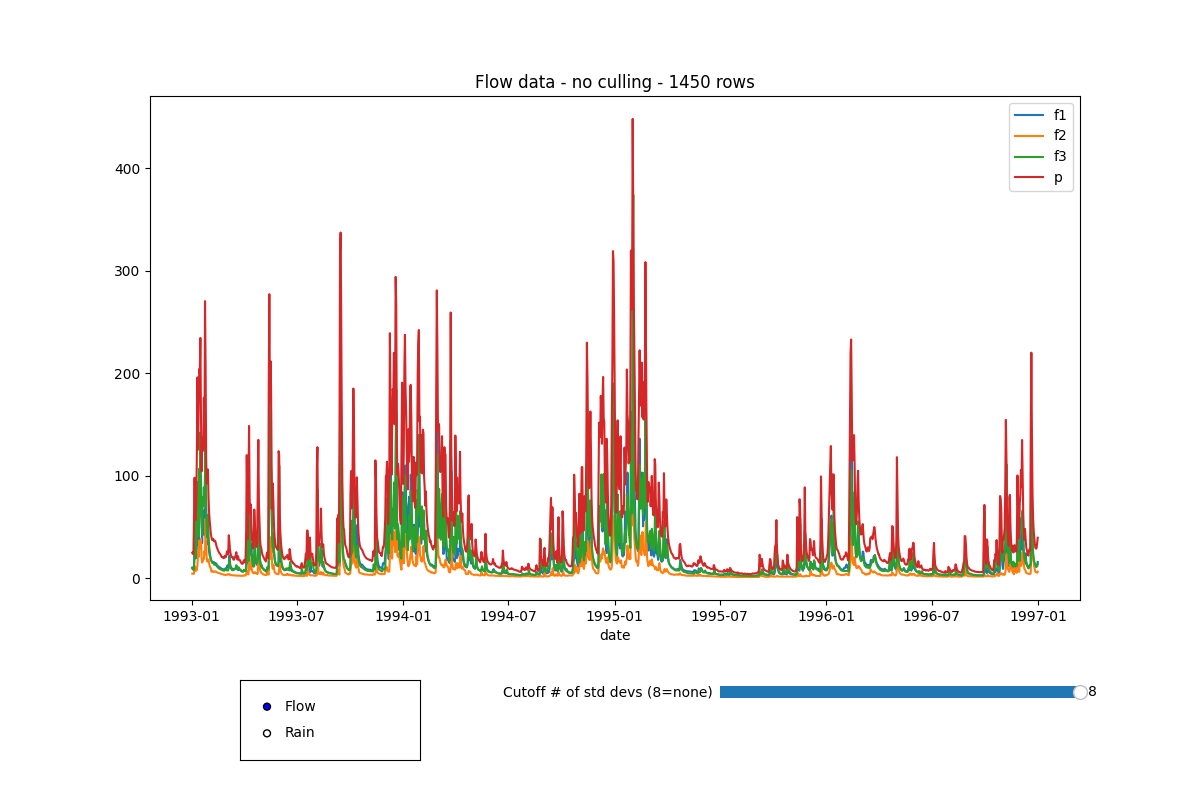

In [137]:
plt.close("all")

# ============================ GRAPHS ==================================


# Line graph showing flow/rain datasets after culling with different std dev values

# Initial graph - flow data with no culling
fig, ax_graph = plt.subplots()
ax_buttons = fig.add_axes([0.2, 0.05, 0.15, 0.1])
ax_slider = fig.add_axes([0.6, 0.12, 0.3, 0.03])
df.loc[:, DF_F_COLS + ["p"]].plot(ax=ax_graph,
    title=f"Flow data - no culling - {initial_df.shape[0]} rows")



# ============================== COMPONENTS ================================


# Radio buttons for flow/rain

dataset_radio = RadioButtons(ax=ax_buttons, labels=["Flow", "Rain"])



# Slider for # of std devs

sd_slider = Slider(ax=ax_slider, label="Cutoff # of std devs (8=none)",
                   valmin=1, valmax=8, valinit=8, valstep=1)

# ======================== EVENT HANDLER FUNCTIONS =======================

def std_update(val):
    dataset = dataset_radio.value_selected
    sd = sd_slider.val

    std_data = df.copy()
    title_text = f"{dataset} data - no culling - {std_data.shape[0]} rows"
    if sd != 8:
        std_data = std_data[np.abs(std_data - std_data.std()) <= std_data.mean() + sd * std_data.std()]
        std_data.dropna(inplace=True)
        title_text = f"{dataset} data - culling values >{sd} std devs from mean - {std_data.shape[0]} rows"

    ax_graph.clear()
    if dataset[0] == "F":
        std_ax_data = std_data.loc[:, DF_F_COLS + ["p"]]
    else:
        std_ax_data = std_data.loc[:, DF_R_COLS + ["p"]]
    std_ax_data.plot(ax=ax_graph, title=title_text)
    fig.subplots_adjust(bottom=0.25)
    fig.canvas.draw()


dataset_radio.on_clicked(std_update)
sd_slider.on_changed(std_update)



# Figure styling
fig.subplots_adjust(bottom=0.25)
fig.set_size_inches((12, 8))
fig.canvas.header_visible = False

### Plot predictand against predictors with transformations

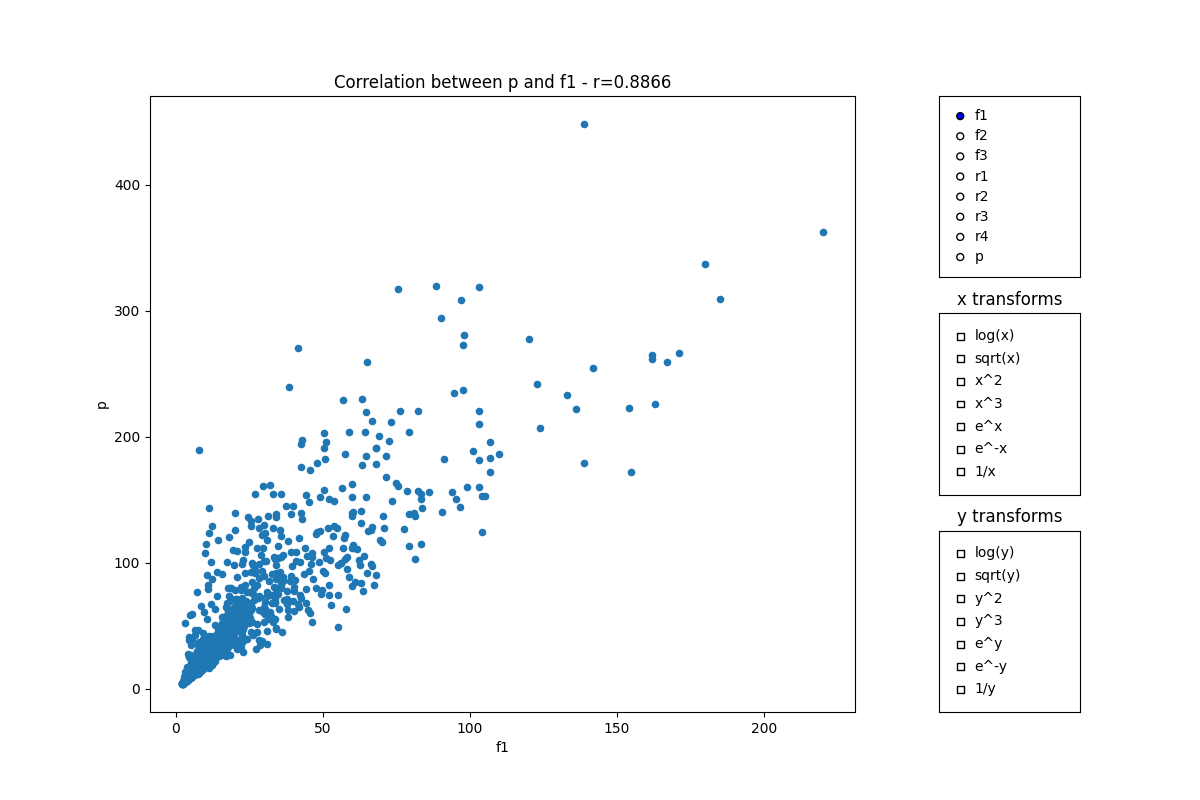

In [139]:
plt.close("all")

# ============================ GRAPHS ==================================


# Line graph showing flow/rain datasets after culling with different std dev values

# Initial graph - flow data with no culling
corr_fig, corr_axes = plt.subplot_mosaic(
    [
        ["main", "xdata"],
        ["main", "x_transforms"],
        ["main", "y_transforms"],
    ],
    width_ratios=[5, 1])
corr_axes["x_transforms"].set_title("x transforms")
corr_axes["y_transforms"].set_title("y transforms")

corr_data = df.copy()
pd_init_x = corr_data.columns[0]
corr_init = corr_data.corr()["p"][pd_init_x]
corr_data.plot(x=pd_init_x, y="p", kind="scatter", ax=corr_axes["main"],
               title=f"Correlation between p and {pd_init_x} - r={corr_init:.4f}")

# ============================== COMPONENTS ================================


# Radio buttons for predictor to plot

predictor_radio = RadioButtons(ax=corr_axes["xdata"],
                               labels=corr_data.columns)

# Check buttons for predictor transforms

def transform_labels(axis):
    return [f"log({axis})",
            f"sqrt({axis})",
            f"{axis}^2",
            f"{axis}^3",
            f"e^{axis}",
            f"e^-{axis}",
            f"1/{axis}",]

x_transform_checks = CheckButtons(ax=corr_axes["x_transforms"],
                                labels=transform_labels("x"))


# Check buttons for predictand transforms

y_transform_checks = CheckButtons(ax=corr_axes["y_transforms"],
                                  labels=transform_labels("y"))

# ======================== EVENT HANDLER FUNCTIONS =======================

def apply_transforms(checks, data):
    transforms = checks.get_status()
    if transforms[0]: data = data.apply(np.log)
    if transforms[1]: data = data.apply(np.sqrt)
    if transforms[2]: data = data.apply(np.square)
    if transforms[3]: data = data.apply(lambda x: np.power(x,3))
    if transforms[4]: data = data.apply(lambda x: np.power(np.e,x))
    if transforms[5]: data = data.apply(lambda x: np.power(np.e, -x))
    if transforms[6]: data = data.apply(lambda x: 1/x if x!=0 else 0)
    return data

def pd_update(val):
    prd = predictor_radio.value_selected

    c_data = corr_data.copy()

    c_data[prd] = apply_transforms(x_transform_checks, c_data[prd])
    c_data["p"] = apply_transforms(y_transform_checks, c_data["p"])

    corr = c_data.corr()["p"][prd]

    corr_axes["main"].clear()
    c_data.plot(x=prd, y="p", kind="scatter", ax=corr_axes["main"],
                title=f"Correlation between p and {prd} - r={corr:.4f}")
    corr_fig.canvas.draw()

predictor_radio.on_clicked(pd_update)
x_transform_checks.on_clicked(pd_update)
y_transform_checks.on_clicked(pd_update)

# Figure styling
corr_fig.set_size_inches((12, 8))
corr_fig.canvas.header_visible = False

### Heatmap of correlations between all columns

In [33]:
heatmap_df = df.corr()
heatmap_df.style.background_gradient(cmap='Reds')

,Crakehill,Skip Bridge,Westwick,Skelton,Arkengarthdale,East Cowton,Malham Tarn,Snaizeholme
Crakehill,1.000000,0.934898,0.959719,0.928095,0.312988,0.195246,0.299671,0.393816
Skip Bridge,0.934898,1.000000,0.907176,0.903532,0.322968,0.221009,0.319665,0.381313
Westwick,0.959719,0.907176,1.000000,0.902338,0.390755,0.230811,0.401054,0.463112
Skelton,0.928095,0.903532,0.902338,1.000000,0.220343,0.093012,0.231984,0.310805
Arkengarthdale,0.312988,0.322968,0.390755,0.220343,1.000000,0.673467,0.684935,0.664943
East Cowton,0.195246,0.221009,0.230811,0.093012,0.673467,1.000000,0.504778,0.459912
Malham Tarn,0.299671,0.319665,0.401054,0.231984,0.684935,0.504778,1.000000,0.701051
Snaizeholme,0.393816,0.381313,0.463112,0.310805,0.664943,0.459912,0.701051,1.000000
